### Imports

In [1]:
%pylab inline
from os.path import abspath, join
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel, SpecifyModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node
import pandas as pd
from glob import glob

Populating the interactive namespace from numpy and matplotlib


### Experiment Variables

In [2]:
experiment_dir = abspath('.')
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-s358']

# list of task identifiers
task_list = ['stroop']

# TR of functional images
TR = .68


###  Specify Contrasts

In [3]:
# Condition names
condition_names = ['response']

# Contrasts
cont01 = ['average','T', condition_names, [1]]

contrast_list = [cont01]

### Specify GLM Model for Motor Contrast

In [4]:
def subjectinfo(subject_id, task, inspect_inputs=False):
    
    from glob import glob
    import numpy as np
    import pandas as pd
    from os.path import join
    from nipype.interfaces.base import Bunch
    
    base_dir = '/home/jovyan/work/output'
    
    # strip "sub" from beginning of subject_id if provided
    subject_id = subject_id.replace('sub-','')
    
    ## Get the Events File
    
    # Read the TSV file and convert to pandas dataframe
    event_file = glob(join(base_dir,
                           'Data',
                           'sub-%s' % subject_id,
                           '*', 'func',
                           '*%s*events.tsv' % task))[0]
    events_df = pd.read_csv(event_file,sep = '\t')
    # set duration and add response column
    events_df.loc[:,'duration'] = .01

    ## Get the Confounds File (output of fmriprep)
    
    # Read the TSV file and convert to pandas dataframe
    confounds_file = glob(join(base_dir,
                               'Data',
                               'sub-%s' % subject_id,
                               '*', 'func',
                               '*%s*confounds.tsv' % task))[0]
    confounds_df = pd.read_csv(confounds_file, sep = '\t', na_values=['n/a']).fillna(0)
    # select relevant regressors
    regressor_names = ['FramewiseDisplacement', 
                       'aCompCor0',
                       'aCompCor1',
                       'aCompCor2',
                       'aCompCor3',
                       'aCompCor4',
                       'aCompCor5']
    # convert selected regressors in dataframe to list of lists
    regressors = confounds_df.loc[:,regressor_names].values.T.tolist()
    
    
    
    subjectinfo = Bunch(conditions=['response'],
                        onsets=[events_df.onset.tolist()],
                         durations=[events_df.duration.tolist()],
                         amplitudes=None,
                         tmod=None,
                         pmod=None,
                         regressor_names=regressor_names,
                         regressors=regressors)

    if inspect_inputs==True:
        return events_df, confounds_df
    else:
        return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id', 'task'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

View one events file used in subject info

In [5]:
events_df,confounds_df = subjectinfo('s358','stroop', True)
confounds_df.head()

,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor0,tCompCor1,tCompCor2,tCompCor3,...,aCompCor2,aCompCor3,aCompCor4,aCompCor5,X,Y,Z,RotX,RotY,RotZ
0,3.129071,-5.173492,0.995423,25.107180,0.954376,0.066566,-0.028548,-0.050399,-0.043659,-0.015710,...,-0.078841,0.067989,-0.008318,0.090335,0.014954,-0.199724,-0.516326,-0.002785,3.350870e-04,-0.000304
1,3.705239,-15.384580,1.056665,26.651878,0.974954,0.116180,-0.019380,-0.027954,0.046011,-0.062212,...,-0.130099,0.016186,-0.010789,0.080306,0.025682,-0.204269,-0.534507,-0.003302,3.123530e-04,-0.000182
2,0.438633,-18.004847,1.060456,26.747486,0.972209,0.080029,-0.016963,0.083715,0.007950,-0.099760,...,-0.094918,0.016897,0.004875,0.061585,0.038782,-0.242088,-0.481399,-0.003517,3.000780e-04,-0.000198
3,-3.488617,-14.283317,0.982462,24.780272,0.941140,0.085458,-0.019241,-0.045433,-0.060118,-0.087091,...,-0.096359,0.120974,0.032313,0.047891,0.034637,-0.239297,-0.433832,-0.003319,8.047130e-23,-0.000186
4,-7.867039,-19.170673,1.040890,26.253975,0.958739,0.049176,-0.008654,-0.051826,0.060073,-0.090306,...,-0.145776,0.014613,0.056545,0.050722,0.030090,-0.200441,-0.442900,-0.002864,1.472280e-04,-0.000243


View bunch

In [6]:
bunch = subjectinfo('s358','stroop')
print('Bunch Keys: ')
[i[0] for i in bunch.items()]

Bunch Keys: 


['amplitudes',
 'pmod',
 'durations',
 'regressor_names',
 'tmod',
 'regressors',
 'conditions',
 'onsets']

### Model Specification

In [7]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

### Specify Input and Output Stream

In [8]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'task',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': join('Data', '{subject_id}','*','func',
                         '*{task}*preproc.nii.gz')}
selectfiles = Node(SelectFiles(templates,
                               base_directory = experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory = experiment_dir,
                         container=output_dir),
                name="datasink")

"""
# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions
"""

"\n# Use the following DataSink output substitutions\nsubstitutions = [('_subject_id_', '')]\nsubjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))\n               for f in fwhm\n               for sub in subject_list]\nsubstitutions.extend(subjFolders)\ndatasink.inputs.substitutions = substitutions\n"

### Workflow

In [9]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('task', 'task')]),
                    (infosource, getsubjectinfo, [('subject_id','subject_id'),
                                                 ('task', 'task')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

### Visualize Workflow

170512-02:04:20,965 workflow INFO:
	 Converting dotfile: /home/jovyan/work/output/workingdir/l1analysis/graph.dot to png format


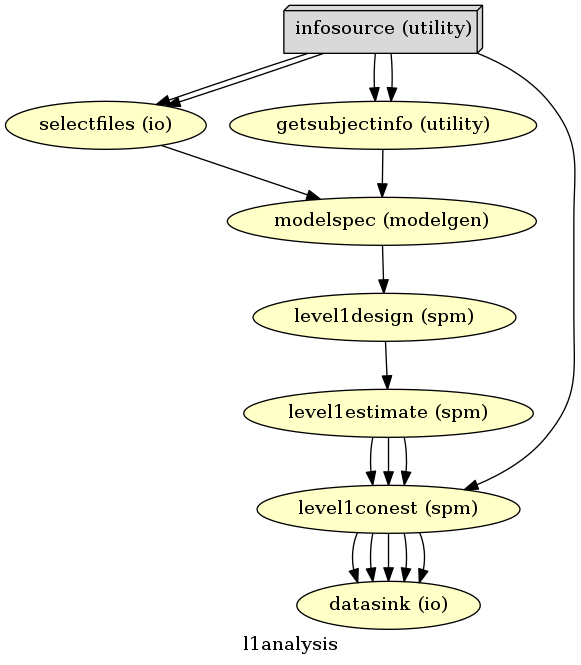

In [10]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=join(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

### Run the Workflow


In [11]:
l1analysis.run()

170512-02:04:29,677 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
170512-02:04:29,705 workflow INFO:
	 Running serially.
170512-02:04:29,707 workflow INFO:
	 Executing node selectfiles.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/selectfiles
170512-02:04:29,733 workflow INFO:
	 Executing node getsubjectinfo.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/getsubjectinfo
170512-02:04:29,869 workflow INFO:
	 Executing node modelspec.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/modelspec
170512-02:04:30,351 workflow INFO:
	 Executing node level1design.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/level1design
170512-02:05:07,944 workflow ERROR:
	 [u'Node level1design.a0 failed to run on host 76957add5ba9.']
170512-02:05:07,946 workflow INFO:
	 Saving crash info to /home/jovyan/w

RuntimeError: Workflow did not execute cleanly. Check log for details

In [ ]:
!tree datasink/1stLevel/_subject*


In [ ]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds102/sub-01/anat/sub-01_T1w.nii.gz'
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)